# Deep Dive `III`

Today we'll be diving into some *unsupervised* ML techniques - **clustering** and **outlier detection**.

In this session our aims are:
1. Generate some data for clusering
1. Use Agglomerative Clustering to label data
1. Explore metrics that measure the quality of a given clustering
1. Understand the KMeans clustering algorithm
1. Use the DBSCAN algorithm to create clusters and assign outliers

## tinyurl.com/ASADeepDive2023

^ Head to this link to access the course materials

Open the file "Deep Dive III - Challenges"

Select File -> "Save a copy in Drive"
(login to google and approve the "colaboratory" app if asked)

## Setting up our session
This is a new notebook so we need to update pandas and import all our modules again

In [ ]:
! pip install --upgrade pandas

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.3/12.3 MB 91.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 341.8/341.8 kB 29.1 MB/s eta 0:00:00
  Attempting uninstall: pandas
    Found existing installation: pandas 1.5.3
    Uninstalling pandas-1.5.3:
      Successfully uninstalled pandas-1.5.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires pandas==1.5.3, but you have pandas 2.0.3 which is incompatible.


In [ ]:
# data reading and manipulation libraries
import numpy as np
import pandas as pd
# plotting libraries
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.cluster.hierarchy import dendrogram
# Machine learning tools
import sklearn
from sklearn.datasets import make_classification
from sklearn.cluster import AgglomerativeClustering, DBSCAN, KMeans
from sklearn.mixture import GaussianMixture
from sklearn import (metrics, model_selection, feature_selection,
                     preprocessing, naive_bayes, linear_model)
print(f"Numpy:        {np.__version__}")
print(f"Pandas:       {pd.__version__} <- ensure this is 2.0 or higher")
print(f"Matplotlib:   {matplotlib.__version__}")
print(f"Seaborn:      {sns.__version__}")
print(f"Scikit-learn: {sklearn.__version__}")

Numpy:        1.22.4
Pandas:       2.0.3 <- ensure this is 2.0 or higher
Matplotlib:   3.7.1
Seaborn:      0.12.2
Scikit-learn: 1.2.2


## Clustering

Clustering is the process of segmenting or dividing a data set into different subsets.
Clustering will be the first of the unserpervised learning tasks that we work with.

To make the clustering process easy to visulaise we will create some synthetic data in three dimensions, assumed to be spatial dimensions.
Another reason for generating our own data, is that we can play with the properties of the data (eg, the number of clusters, or the fraction of noisy data points), to understand how the clustering algorithms perform.

The code below will generate a pre-determined number of clusters in the data, however this is just part of the data generation stage, not "the answer".


![Challenge](https://cdn.icon-icons.com/icons2/2110/PNG/64/challenge_icon_131034.png)

Review the code below and then execute it to define our helper function.

In [ ]:
def make_clusters(n_samples=1000, n_noise=100, clusters=3):
  """
  Create some clusters in a 3d data set

  parameters
  ----------
  n_samples : int
    The number of samples that belong to clusers

  n_noise : int
    The number of samples that are noise (may overlap clusers)

  clusters : int
    Total number of clusters

  returns
  -------
  X : pandas.DataFrame
  """

  X, _ = make_classification(n_samples=n_samples,
                            n_features=3,
                            n_informative=3,
                            n_redundant=0,
                            n_clusters_per_class=1,
                            n_classes=clusters,
                            class_sep=3,
                            random_state=15)

  X -= X.mean()
  X /= X.std()
  X = np.vstack([X, np.random.normal(size=(n_noise,3))])
  X = pd.DataFrame(X, columns = ['a','b','c'])
  return X

Since we are doing unsupervised meachine learning we no longer have a set of known answers that we are aiming for.
Thus we will have a matrix of data ($X$) but no vector of solutions ($y$).

![Challenge](https://cdn.icon-icons.com/icons2/2110/PNG/64/challenge_icon_131034.png)

Start by creating our data matrix using the default values in the above code.

In [ ]:
X = make_clusters()

Use the `sns.pairplot` to visualise the data.

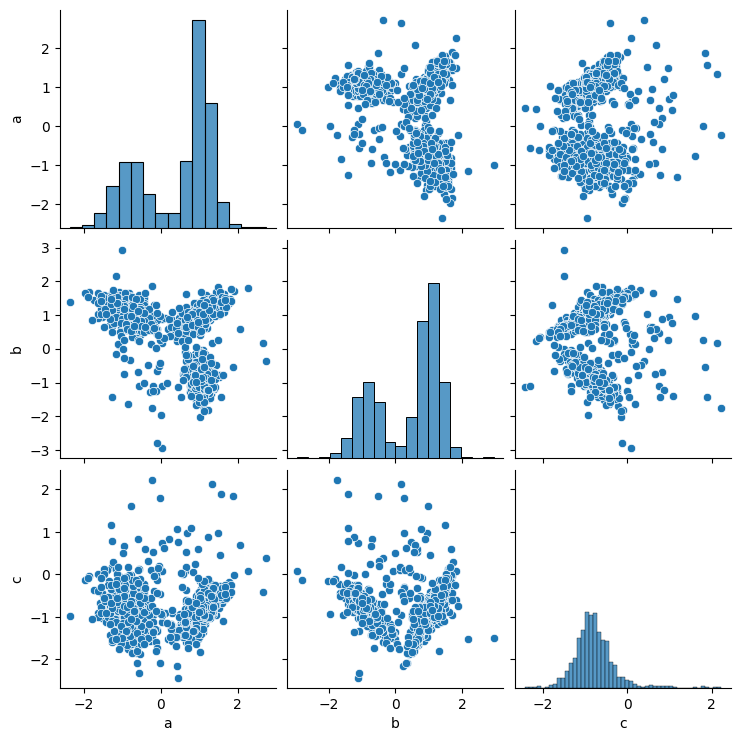

In [ ]:
sns.pairplot(X) # Make 3d interactive plot

In the above plot, see if you can identify the three groups of points that we simulated.
The simulation includes noise, and the groups of points partially overlap, so there is no clear right answer as to how many clusters there are or what their shape should be.

## Agglomerative Clustering


We are going to start with a heirarchical clustering algorithm called Agglomerative Clustering.
In this model we start sart at the 'bottom' of the heirarchy and follow the process:
1. Every data point is it's own cluster
1. Search for the two clusters which are the most similar (closest)
1. Join these two clusters together into a new cluster
1. If we have more clusters than desired GOTO (2)
1. Report on the clusters.

In the Agglomerative Clustering model we have the option to give the number of clusters as an input parameter.
The clustering will stop when there are this many clusters.
This is a bottom-up clustering model where we start with many small clusters and join them together.
There are other clustering methods that do the inverse - start with one large group and then split the group until you reach the required number of clusters.

We also have the option of not providing a target cluster number, which will cause the algorithm to return to us all of the clusters that were made from N ... 1.

![Challenge](https://cdn.icon-icons.com/icons2/2110/PNG/64/challenge_icon_131034.png)

Run the `AgglomerativeClusering` model with the `n_cluster` equal to `None` so that it will generate the full heirarchy of clusters.

In [ ]:
# create the model
model_ac_full = AgglomerativeClustering(distance_threshold=0, #if n_clusters is None, then we have to set this parameter.
                                        n_clusters=None)

# Fit the model
model_ac_full.fit(X)

AgglomerativeClustering(distance_threshold=0, n_clusters=None)

There is a convenience function in scikit learn to create a dendrogram, but it requires some pre-work, so we'll wrap that in a convenience function.

In [ ]:
def plot_dendrogram(model, **kwargs):
  """
  Plot a dendorgram coresponding to a given clustering scheme
  """
  # Create linkage matrix and then plot the dendrogram
  # create the counts of samples under each node
  counts = np.zeros(model.children_.shape[0])
  n_samples = len(model.labels_)
  for i, merge in enumerate(model.children_):
      current_count = 0
      for child_idx in merge:
          if child_idx < n_samples:
              current_count += 1  # leaf node
          else:
              current_count += counts[child_idx - n_samples]
      counts[i] = current_count
  linkage_matrix = np.column_stack([model.children_, model.distances_,
                                    counts]).astype(float)
  # Plot the corresponding dendrogram
  dendrogram(linkage_matrix, **kwargs)

![Challenge](https://cdn.icon-icons.com/icons2/2110/PNG/64/challenge_icon_131034.png)

Plot the dendrogram using just the first 5 levels

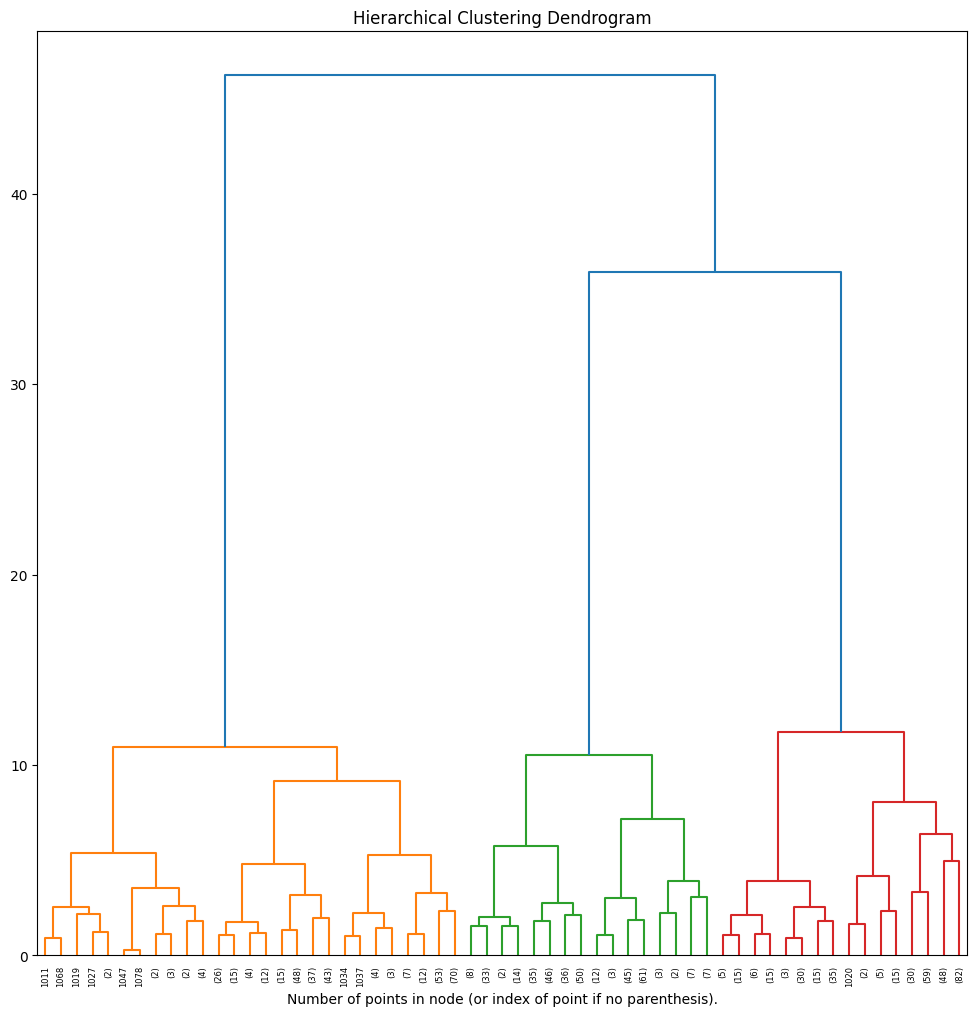

In [ ]:
# Now plot the dendrogram.
plt.figure(figsize=(12,12))
plt.title('Hierarchical Clustering Dendrogram')
# plot the top five levels of the dendrogram
plot_dendrogram( model_ac_full,  # the clustering model
                truncate_mode='level', # we want to only plot some of the tree, stopping at a given level
                p=5, # stop plotting at 5 levels deep
                 )
plt.xlabel("Number of points in node (or index of point if no parenthesis).")
plt.show()

In the dendrogram above, we can see along the bottom of the plot all the points or clusters that existed at a point in the merger history.
Each time two groups are merged together they produce a little top hat Π, and the height of that top hat shows the distance between the two clusters (vertical axis).
As you can see the plot has been coloured with orange, green, and red, to indicate that there are likely to be 3 clusters in the data set.

How is three the right number?

Well, the goal of clustering is to group things together that are similar to each other but different from other things.
If we look for the tallest Π in the chart, we will find the point at which there is maximum separation between the clusters at that point in the heirarchy.
Another way to think of this is to look for the largest veritcal span for which there are a consistent number of clusters.

![Challenge](https://cdn.icon-icons.com/icons2/2110/PNG/64/challenge_icon_131034.png)

Remake our model, but this time specify the number of clusters to be 3

In [ ]:
model_ac = AgglomerativeClustering(n_clusters=3) # Three is what the model said

Now we 'train' the model on the data and predict the groups for each data point.

In [ ]:
# label each data point as belonging to one of three clusters
y_pred = model_ac.fit_predict(X)
# turn the y_pred into a pandas Series so that we can join it to a DataFrame
y_pred = pd.Series(y_pred, name='class')

![Challenge](https://cdn.icon-icons.com/icons2/2110/PNG/64/challenge_icon_131034.png)

Redo our corner plot as before, but this time colour the datapoints according to their clusters.

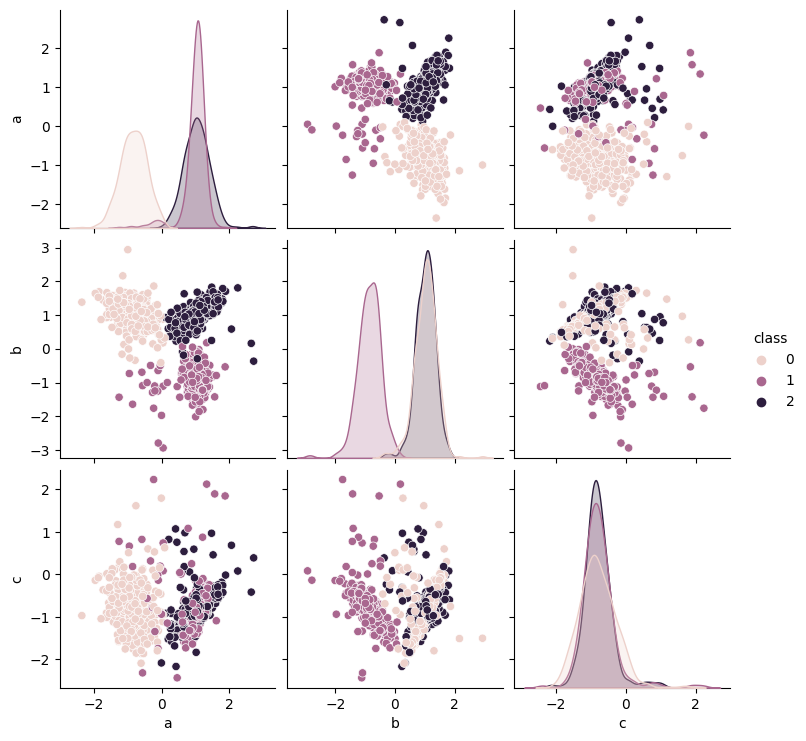

In [ ]:
sns.pairplot(X.join(y_pred), hue='class')

## Evaluating clustering methods

Since this is unsupervised learning, we don't have a predetermined set of answers that we can compare our results to.
We therefore need to rely on internal validation.

In order to assess the quality of the clustering method we can visualise it as we did above, but it would be great to have some quantitative measures so that we can do some hyper-parameter optimisation and get the "best" results.

There are a number of metrics that we can use:
1. Sum of squared errors
1. Silhouette Measure
1. Davies-Bouldin score

The numerical values that these metrics give are only useful when comparing between results from the same model.
That is, they are a good way to determine the "right" number of clusters in the data, however they are not always good for comparing results between different clustering methods.

### Sum of squared errors (SSE)
In this metric we look at each cluster and compute a mean location for that cluster.
We then take the sum of the square of the difference between each point in the cluster and that mean location.
Finally you sum this value across all the clusters.

Mathemetically we have:
$$
SSE = \Sigma_{clusters}(\Sigma_{points} (x_i -\mu)^2))
$$

And visually we have:

![SSE](https://moderatewings.files.wordpress.com/2018/05/screen-shot-2018-05-29-at-11-27-48-pm.png?w=690)

Somehow `scikit-learn` doesn't provide an SSE metric so we have to create it ourselves.

In [ ]:
def sse(X, yhat):
  """
  Calculate the sum of squared errors for clusters in X with labels in y
  """
  clusters = pd.unique(yhat)
  ssq = 0
  for c in clusters:
    cluster = X[yhat==c]
    centroid = cluster.mean(axis=0)
    distances = cluster-centroid
    ssq += (distances**2).sum()
  return ssq.sum()

![Challenge](https://cdn.icon-icons.com/icons2/2110/PNG/64/challenge_icon_131034.png)

Evaluate the SSE metric on our agglomative clustering with 3 clusters.

In [ ]:
print(f"SSE = {sse(X, y_pred):.1f}")

SSE = 558.7


Since the above number is not useful on it's own, we need some other values to compare against.

![Challenge](https://cdn.icon-icons.com/icons2/2110/PNG/64/challenge_icon_131034.png)

Loop over cluster values from 2->7 and see which has the lowest SSE.

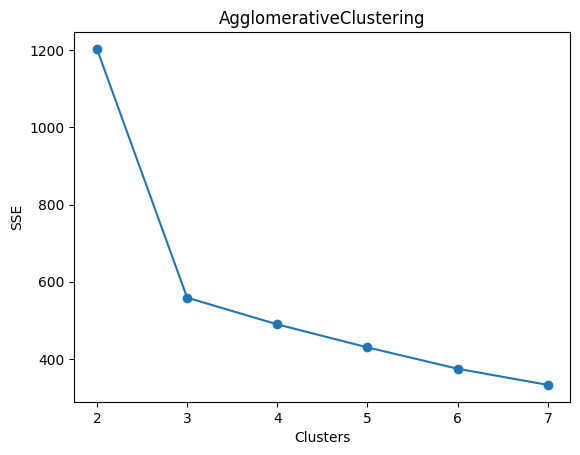

In [ ]:
# create a list of cluster values to test
clusters = list(range(2,8))

# loop over and record the
sse_vals = []
for k in clusters:
  m = AgglomerativeClustering(n_clusters=k)
  yhat = m.fit_predict(X)
  err = sse(X,yhat)
  sse_vals.append(err)

# make the plot
plt.plot(clusters, sse_vals,'o-')
ax = plt.gca()
ax.set_xlabel('Clusters')
ax.set_ylabel('SSE')
ax.set_title('AgglomerativeClustering')
ax.set_xticks(clusters)
plt.show()

From the above plot it appears that as we make more and more clusters the SSE decreases.
This is always going to be true, so how do we select the 'best' number of clusters?

We look for a break in the behaviour of the curve or a 'knee'.
In the curve above this occurs around 3-4 clusters, so the answer is not so definitive.

### Silhouette Measure


As the name suggests, this measure is meant to determine how much overlap there is between clusters.

The silhouette score for an individual point is measured by determining the average distance between that point and all the others in the cluster, $a(i)$ and the distance to the nearest point in a different cluster, $b(i)$.
This is then normalised by the maximum of $a(i)$ and $b(i)$.
Thus the silhouette score is between -1 and +1

![Silhouette](https://uploads-ssl.webflow.com/5f5148a709e16c7d368ea080/5f7dea907b8e8c7769e769c8_5f7c9650bc3b1ed0ad2247eb_silhouette_formula.jpg)

A value close to -1 means that the data point is in the wrong cluster, or that the clusters are overlapping each other, and a value of +1 means that the point is well separated from other clusters.

The mean of the silhouette measure across all data points can be used to assess how well the clustering has been achieved.

![Challenge](https://cdn.icon-icons.com/icons2/2110/PNG/64/challenge_icon_131034.png)

Use the `scikit-learn` function `metrics.silhouette_score` to compute the score for a range of clusters and determin the best number of clusters for our dataset.

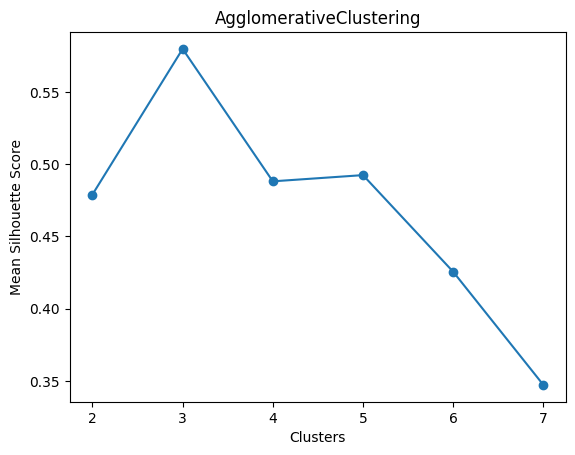

In [ ]:
# create a list of cluster values to test
clusters = list(range(2,8))

# loop over and record the
sm_vals = []
for k in clusters:
  m = AgglomerativeClustering(n_clusters=k)
  yhat = m.fit_predict(X)
  err = metrics.silhouette_score(X,yhat)
  sm_vals.append(err)

# make the plot
plt.plot(clusters, sm_vals,'o-')
ax = plt.gca()
ax.set_xlabel('Clusters')
ax.set_ylabel('Mean Silhouette Score')
ax.set_title('AgglomerativeClustering')
ax.set_xticks(clusters)
plt.show()

From the above plot we should now be looking for a **maximum** value of the silhouette score to choose the best number of clusters.

In this case we got a clear answer of 4 clusters!

### Davies-Bouldin

The Davies-Bouldin score is calculated by looking at all possible pairs of data points, and partitioning them into pairs within the same cluster (P) and pairs from different clusters (Q).

The average of the distances between pairs P is the intra-cluster variance, and the averange of the distances between paris Q is the inter-cluster variance.

The Davies-Bouldin score is the ratio of these two values.

![DB](https://drek4537l1klr.cloudfront.net/rhys/v-6/Figures/CH16_FIG_4_MLR.png)

Smaller values of this metric indicate a better separation of clusters.

![Challenge](https://cdn.icon-icons.com/icons2/2110/PNG/64/challenge_icon_131034.png)

Use the `scikit-learn` function `metrics.davies_bouldin_score` to compute the score for a range of clusters and determine the best number of clusters for our dataset.

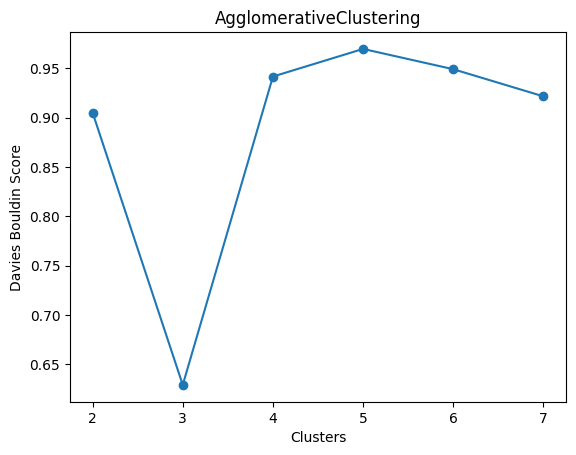

In [ ]:
# create a list of cluster values to test
clusters = list(range(2,8))

# loop over and record the
db_vals = []
for k in clusters:
  m = AgglomerativeClustering(n_clusters=k)
  yhat = m.fit_predict(X)
  err = metrics.davies_bouldin_score(X,yhat)
  db_vals.append(err)

# make the plot
plt.plot(clusters, db_vals,'o-')
ax = plt.gca()
ax.set_xlabel('Clusters')
ax.set_ylabel('Davies Bouldin Score')
ax.set_title('AgglomerativeClustering')
ax.set_xticks(clusters)
plt.show()

In the above plot there is a clear minimum score at 3 clusters.

![Challenge](https://cdn.icon-icons.com/icons2/2110/PNG/64/challenge_icon_131034.png)

If you didn't "know" that there should be three clusters, how many clusters would you think there are in the data set?

Why is so hard to determine the number of clusters?

If the aglomerative clustering isn't giving clear results, then maybe a differnt clustering method would help.

## K-Means clustering

The K-Means clustering algorithm is an interative altorithm that enforces a particular number of clusters onto your data set.

The way that K-Means works is to define a mean location for each cluster, and then each data point is assigned to the nearest cluster.
The process iterates between:
1. Compute the mean location for each cluster
1. Assign data points to the nearest cluster
1. Goto (1) until some stopping condition is met

The stopping condition is typically some kind of convergence check.
For example, if you assign data points to the same clusters that they had in the previous iteration then you have converged.

The following animation nicely shows the iterative approach for three clusters, usin green/bue/red as the cluster labels, and ⭐ as the mean of each cluster.

![kmeans_ani](https://miro.medium.com/v2/resize:fit:640/1*xkuet4YVglp8KWsK90bfRw.gif)

Since we are going to go through the same series of tasks as above, it's probably a good idea to write a function that does all the repetative work for us.

In [ ]:
def plot_metrics(X,model):
  fig, axs = plt.subplots(1,3, figsize=(18,6))
  for ax, metric in zip(axs, [sse, metrics.davies_bouldin_score, metrics.silhouette_score]):
    errs = []
    for k in range(2,8):
      m = model(n_clusters=k)
      yhat = m.fit_predict(X)
      err = metric(X,yhat)
      errs.append(err)
    k_vals = range(2,len(errs)+2)

    ax.plot(k_vals,
            errs,
            'o-')
    ax.set_xlabel('Clusters')
    ax.set_ylabel(metric.__name__)
    ax.set_title(model.__name__)
    ax.set_xticks(k_vals)
  plt.show()


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:8

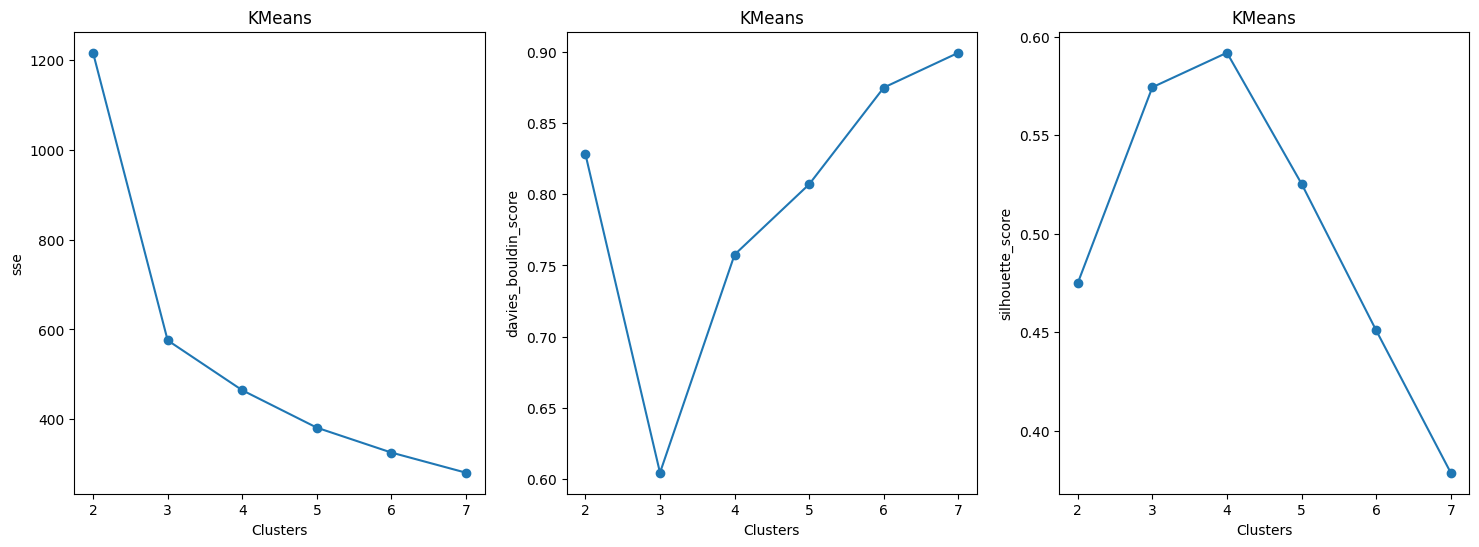

In [ ]:
plot_metrics(X, KMeans)
# Ignore the FutureWarning notices below!

From the above plots, are we any closer to determining the number of clusers in our dataset?

![Challenge](https://cdn.icon-icons.com/icons2/2110/PNG/64/challenge_icon_131034.png)

Run the `plot_metrics` again, but this time generate a new data set that has no noise at all.

Try again with 10, 50, and 500 noise points to see how outliers in our distribution affect our ability to generate clusters.

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:8

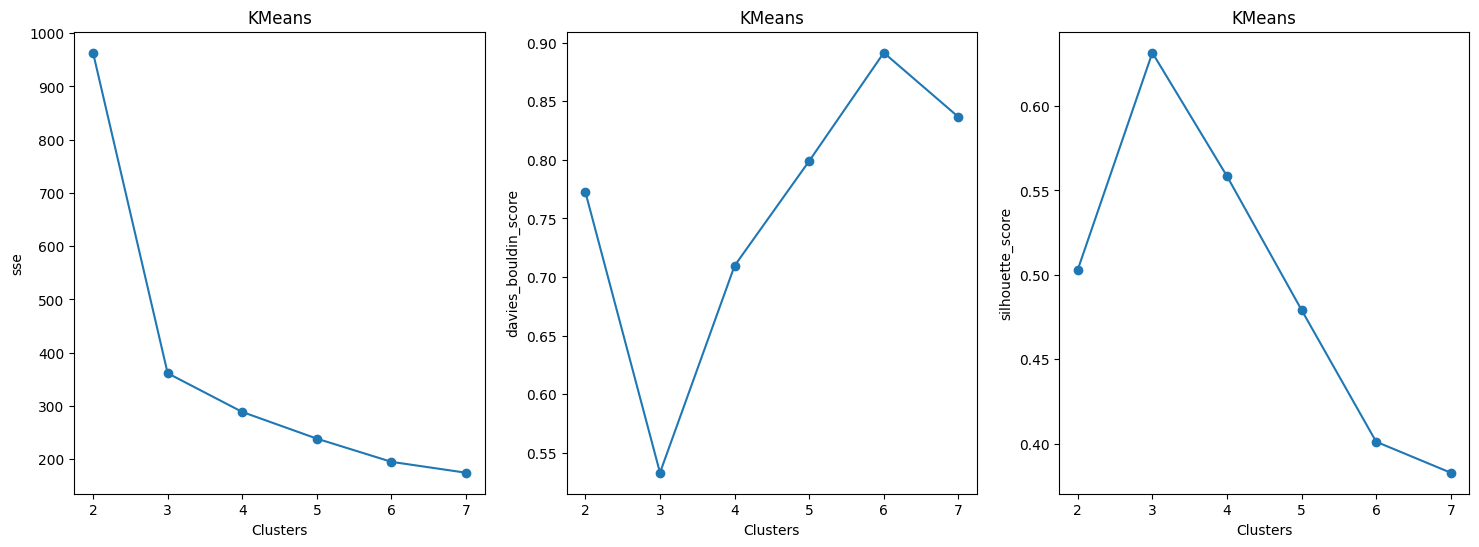

In [ ]:
X = make_clusters(n_noise=10)
plot_metrics(X, KMeans)

## DBSCAN

Density-based spatial clustering of applications with noise (DBSCAN) is a data clustering algorithm.
DBSCAN doesn't require a number of clusters in order to work but instead requires a linking criteria or distace threshold.

DBSCAN works by looking at each point of data and assigning it as either:
1. A **core** point if there are more the `minpts` neighbors within a distance of ϵ.
1. A **border** point if there are less than `minpts` neighbors within a distance of ϵ, but there is at least one **core** with that distance.
1. A **noise** or **outlier** point otherwise

In the diagram below you can see the core points 🟦, border points ⚫, and noise points ⚪, as well as the distance ϵ, around the core points.

![DBSCAN](https://miro.medium.com/max/627/1*yT96veo7Zb5QeswV7Vr7YQ.png)

![Challenge](https://cdn.icon-icons.com/icons2/2110/PNG/64/challenge_icon_131034.png)

Use the `DBSCAN` model with an `eps` of between 0.2 and 0.3, and with `min_samples` of 5.

Make a pairplot to show your clustering.

In [ ]:
dbs = DBSCAN(eps=0.25, min_samples=5)
y_hat = dbs.fit_predict(X)

In [ ]:
y_hat = pd.DataFrame(data=y_hat, columns=['class'])

In [ ]:
sns.pairplot(X.join(y_hat), hue='class', palette=sns.color_palette("colorblind"))

How many clusters do you see in the above plot?

Whay is there a cluster with label of -1?

## END

Thank you for working through the Deep Dive sessions that we have prepared for the ASA meeting.

If you are interested in doing more with machine learning you shoudl consider joining the Machine Learning in Australian Astronomy (MLAA) slack [LINK](https://join.slack.com/t/mlaa-workspace/shared_invite/zt-1yp4cocg4-ekc7gVuDE0BGvrF8Lm45eQ).

If you are interested in how ADACS can help you engage with machine learning in your work please visit our website at [adacs.org.au](https://adacs.org.au/).